### メモ
パラメータチューニング、Data Augmentationを行う。また、Data Augmentation なしの場合も行う

### Library 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.preprocessing .image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import datetime
import optuna
from optuna_dashboard.app import create_app
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler, GridSampler
from sklearn.manifold import TSNE
from keras.callbacks import TensorBoard
from tqdm import tqdm
import umap

2023-12-22 17:10:58.318636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 17:10:58.318698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 17:10:58.606011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 17:10:59.326014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 17:11:05.325164: W tensorflow/compiler/tf2

In [4]:
folds = 10
n_trials = 50

### Data

(50000, 32, 32, 3)


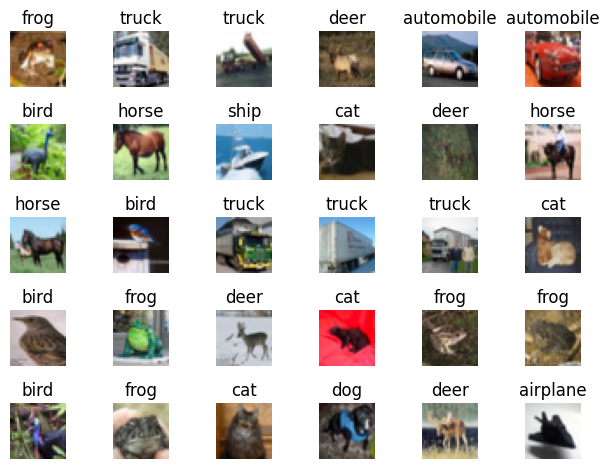

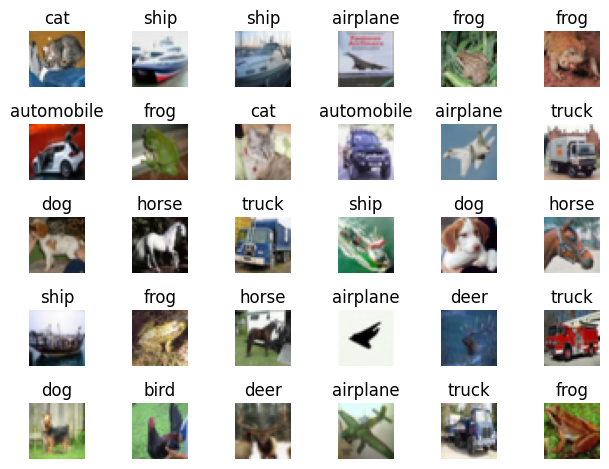

num_class: 10


In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)

#ラベルの設定
labels = np.array([
    'airplane',  #飛行機
    'automobile',#バイク
    'bird',      #鳥
    'cat',       #猫
    'deer',      #鹿
    'dog',       #犬
    'frog',      #カエル
    'horse',     #馬
    'ship',      #船
    'truck'      #トラック
    ])

#画像の表示のための関数
def image_show(x, y, labels):
    for i in range(30):
        plt.subplot(5, 6, i+1)
        #軸を表示しない
        plt.axis("off")
        #タイトルをラベルの名前で表示
        plt.title(labels[y[i][0]])
        #表示
        plt.imshow(x[i])
    plt.tight_layout()
    plt.show()
    return    

# トレーニングデータの画像とラベルをセットで表示してみる
image_show(X_train, y_train, labels)
image_show(X_test, y_test, labels)

# データの前処理
# ラベルをバイナリクラスにする(yの値を10この数値の配列に変換している)
categorical_y_train = to_categorical(y_train, 10)
categorical_y_test = to_categorical(y_test, 10)

# 正解ラベルの中身の種類 (0~9)をlistに格納
class_list = np.unique(y_train).tolist()
num_class = len(class_list)
print("num_class:", num_class)

### ImageDataGenerator

In [6]:
# ImageDataGeneratorクラスの作成
augmentation_train_datagen = ImageDataGenerator(
    rotation_range=10,          # 回転
    horizontal_flip=True,       # 左右反転
    height_shift_range=0.2,     # 上下平行移動
    width_shift_range=0.2,      # 左右平行移動
    zoom_range=0.2,             # ランダムにズーム
    channel_shift_range = 0.2,  # チャンネルシフト
    rescale=1./255              # スケーリング
)

### Model

In [7]:
def create_model(trial):
    # モデル作成時のパラメータを設定
    n_layers = trial.suggest_int('n_layers', 1, 10)
    exponentU = trial.suggest_int('exponentU', 5, 12)
    units = 2**exponentU
    drop = trial.suggest_float('drop', 0.1, 0.5, step=0.1)

    inputs = Input(shape=X_train[0].shape)
    x = Conv2D(64, (3,3), padding = "same", activation="relu")(inputs)

    for i in range(n_layers):
        x = Conv2D(units*2**(i-1), (3,3), padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2,2), padding="same")(x)
        # x = Dropout(drop)(x)

    intermediate_layer = Conv2D(32, (3,3), padding="same", activation="relu")(x)

    # 平滑化
    x = Flatten()(intermediate_layer)

    # 全統合
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_class, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=predictions)

    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'RMSProp'])

    model.compile(loss="categorical_crossentropy",
                    optimizer=optimizer,
                    metrics=["accuracy"]
                    )
    
    intermediate_layer_model = Model(inputs=inputs, outputs=intermediate_layer)
    
    return model, intermediate_layer_model

### Parameter tuning

In [8]:
def objective(trial):
    # モデルの作成
    model, intermediate_layer_model = create_model(trial)

    # batch_size範囲を指定
    exponentB = trial.suggest_int('exponentB', 4, 10)
    batch_size = 2**exponentB
    exponentE = trial.suggest_int('exponentE', 4, 9)
    epochs = 2**exponentE

    # KFold のオブジェクトを作成
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    
    print("num_X_train:", len(X_train))
    
    accuracy_list = []
    for train_index, valid_index in kf.split(X_train, categorical_y_train):
        X_train_subset = X_train[train_index]
        y_train_subset = categorical_y_train[train_index]
        X_valid_subset = X_train[valid_index]
        y_valid_subset = categorical_y_train[valid_index]


        # データ拡張を適用
        train_generator = augmentation_train_datagen.flow(X_train_subset, y_train_subset,batch_size=batch_size)

        # 学習
        model.fit(train_generator,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_valid_subset, y_valid_subset),
                    callbacks=[EarlyStopping(patience=10)]
        )

        # 予測
        y_pred_subset = model.predict(X_valid_subset)

        # 予測したものを元のカテゴリクラスに変換する
        y_pred_subset = np.argmax(y_pred_subset, axis=1)
        y_valid_subset = np.argmax(y_valid_subset, axis=1)

        # 正解数をカウント
        num_correct = np.sum(y_pred_subset == y_valid_subset)
        print("num_correct:", num_correct)

        # valid_index の数
        num_valid_samples = len(y_valid_subset)
        print("num_valid_samples:", num_valid_samples)

        # 正解率
        accuracy = num_correct / num_valid_samples
        print("accuracy:", accuracy)

        # 正解率をリストにappend
        accuracy_list.append(accuracy)

    # CVのaccuracyの平均値を目的関数として返す
    print(np.mean(accuracy_list))
    return np.mean(accuracy_list)


# ベイズ最適化
sampler = TPESampler()
storage_path = f"sqlite:////home/gakubu/デスクトップ/ML_git/MLT/ML_11/example.db"
study = optuna.create_study(sampler=sampler, direction="maximize", storage=storage_path)
study.optimize(objective, n_trials=n_trials)
# 最適なパラメータの表示
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

model, intermediate_layer_model = create_model(study.best_trial)

[I 2023-12-22 17:11:34,076] A new study created in RDB with name: no-name-6d047853-462a-40e0-823e-075a028fc671


num_X_train: 50000
Epoch 1/16
2813/2813 [==============================] - 67s 24ms/step - loss: 1.7332 - accuracy: 0.3678 - val_loss: 358.9633 - val_accuracy: 0.2168
Epoch 2/16
2813/2813 [==============================] - 68s 24ms/step - loss: 1.4965 - accuracy: 0.4581 - val_loss: 495.9461 - val_accuracy: 0.2020
Epoch 3/16
2195/2813 [======================>.......] - ETA: 14s - loss: 1.3825 - accuracy: 0.5032

[W 2023-12-22 17:14:42,155] Trial 0 failed with parameters: {'n_layers': 1, 'exponentU': 5, 'drop': 0.2, 'optimizer': 'sgd', 'exponentB': 4, 'exponentE': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/gakubu/.local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3780/3949828017.py", line 28, in objective
    model.fit(train_generator,
  File "/home/gakubu/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/gakubu/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gakubu/.local/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", li

KeyboardInterrupt: 

### Log

In [ ]:
keras.utils.plot_model(model, to_file="/home/gakubu/デスクトップ/ML_git/MLT/ML_11/aug_best_model.png", 
                        show_shapes=True, show_layer_activations="True")
# tensorboard を使用
log_dir = "/home/gakubu/デスクトップ/ML_git/MLT/ML_11/fit_1222/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

### Learn

In [ ]:
batch_size = 2**study.best_trial.params['exponentB']
epochs = 2**study.best_trial.params['exponentE']
# データ拡張を適用
train_generator = augmentation_train_datagen.flow(X_train, categorical_y_train,batch_size=batch_size)

# 学習
history = model.fit(train_generator,
                epochs=epochs,
                verbose=1,
                validation_data=(X_test, categorical_y_test),
                callbacks=[tensorboard_callback, 
                            EarlyStopping(patience=10)]

)

### Evaluation

In [ ]:
# テストデータに対する予測
y_test_pred = model.predict(X_test)
# 予測したものを元のカテゴリクラスに変換する
y_test_pred = np.argmax(y_test_pred, axis=1)
y_test_pred_labels = y_test_pred.reshape(-1, 1)
# データの形を確認
print("y_test_pred_labels:", y_test_pred_labels)
print("y_test:", y_test)
# 予測と正解ラベルが異なる画像のインデックスを取得
misclassified_indices = np.where(y_test_pred != np.argmax(categorical_y_test, axis=1))[0]
print("misclassified_indices:", misclassified_indices)
# 表示する画像の枚数
num_images_to_display = min(50, len(misclassified_indices))
num_miss_categorized = len(misclassified_indices)
print("Num miss categorized:", num_miss_categorized)
# グリッドの行数と列数を計算
num_rows = int(np.sqrt(num_images_to_display))
num_cols = int(np.ceil(num_images_to_display / num_rows))
# 誤分類された画像を表示
for i in range(num_images_to_display):
    index = misclassified_indices[i] 

    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(X_test[index])
    plt.axis("off")
    titles = labels[y_test_pred_labels[index][0]] + "," + labels[y_test[index][0]]
    plt.title(titles)
plt.tight_layout()
plt.show()

# 正解数をカウント
num_correct = len(y_test) - num_miss_categorized

# valid_index の数
num_valid_samples = len(y_test)

# 正解率
print("num_correct:", num_correct)
print("num_valid_samples:", num_valid_samples)
accuracy = num_correct / num_valid_samples
print("accuracy:", accuracy)

### 中間層の出力を取得

In [ ]:
intermediate_output = intermediate_layer_model.predict(X_train)
data_for_embedding = intermediate_output.reshape(intermediate_output.shape[0], -1)

### TSNE

In [ ]:
# t-SNEによる次元削減
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_for_embedding)
# プロット
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_train.flatten(), cmap="tab10")
plt.legend(*scatter.legend_elements())
plt.title('t-SNE Visualization of Convolutional Features')
plt.show()

### UMAP

In [ ]:
umap = umap.UMAP(random_state=42)
umap_result = umap.fit_transform(data_for_embedding)
print(umap_result.shape)
# プロット
u_scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=y_train.flatten(), cmap="tab10", s=0.7)
plt.legend(*u_scatter.legend_elements())
plt.title('UMAP Visualization of Convolutional Features')
plt.show()

## Without Data Augmentation

### Parameter Tunig without Data Augmentation

In [ ]:
def objective(trial):
    # モデルの作成
    model_n, intermediate_layer_model = create_model(trial)

    # batch_size範囲を指定
    exponentB = trial.suggest_int('exponentB', 4, 10)
    batch_size = 2**exponentB
    exponentE = trial.suggest_int('exponentE', 3, 6)
    epochs = 2**exponentE

    # KFold のオブジェクトを作成
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    
    print("num_X_train:", len(X_train))
    
    accuracy_list_n = []
    for train_index, valid_index in kf.split(X_train, categorical_y_train):
        X_train_subset = X_train[train_index]
        y_train_subset = categorical_y_train[train_index]
        X_valid_subset = X_train[valid_index]
        y_valid_subset = categorical_y_train[valid_index]


        # 学習
        model_n.fit(X_train_subset, y_train_subset,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_valid_subset, y_valid_subset),
                    callbacks=[EarlyStopping(patience=10)]
        )

        # 予測
        y_pred_subset = model_n.predict(X_valid_subset)

        # 予測したものを元のカテゴリクラスに変換する
        y_pred_subset = np.argmax(y_pred_subset, axis=1)
        y_valid_subset = np.argmax(y_valid_subset, axis=1)

        # 正解数をカウント
        num_correct_n = np.sum(y_pred_subset == y_valid_subset)
        print("num_correct:", num_correct_n)

        # valid_index の数
        num_valid_samples_n = len(y_valid_subset)
        print("num_valid_samples:", num_valid_samples_n)

        # 正解率
        accuracy_n = num_correct_n / num_valid_samples_n
        print("accuracy:", accuracy)

        # 正解率をリストにappend
        accuracy_list_n.append(accuracy)

    # CVのaccuracyの平均値を目的関数として返す
    print(np.mean(accuracy_list_n))
    return np.mean(accuracy_list_n)


# ベイズ最適化
sampler = TPESampler()
storage_path = f"sqlite:////home/gakubu/デスクトップ/ML_git/MLT/ML_11/normal_example.db"
study = optuna.create_study(sampler=sampler, direction="maximize", storage=storage_path)
# 最適なパラメータの表示
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

normal_model, normal_intermediate_layer_model = create_model(study.best_trial)

### Log

In [ ]:
keras.utils.plot_model(model, to_file="/home/gakubu/デスクトップ/ML_git/MLT/ML_11/best_model.png", 
                        show_shapes=True, show_layer_activations="True")
# tensorboard を使用
log_dir = "/home/gakubu/デスクトップ/ML_git/MLT/ML_11/fit_1222/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

### Learn

In [ ]:
batch_size = 2**study.best_trial.params['exponentB']
epochs = 2**study.best_trial.params['exponentE']

# 学習
history_n = normal_model.fit(X_train, categorical_y_train,
                epochs=epochs,
                verbose=1,
                validation_data=(X_test, categorical_y_test),
                callbacks=[tensorboard_callback, 
                            EarlyStopping(patience=10)]

)

### Evaluation 

In [ ]:
# テストデータに対する予測
y_test_pred_n = normal_model.predict(X_test)
# 予測したものを元のカテゴリクラスに変換する
y_test_pred_n = np.argmax(y_test_pred_n, axis=1)
y_test_pred_labels_n = y_test_pred_n.reshape(-1, 1)
# データの形を確認
print("y_test_pred_labels:", y_test_pred_labels_n)
print("y_test:", y_test)
# 予測と正解ラベルが異なる画像のインデックスを取得
misclassified_indices_n = np.where(y_test_pred_n != np.argmax(categorical_y_test, axis=1))[0]
print("misclassified_indices:", misclassified_indices_n)
# 表示する画像の枚数
num_images_to_display_n = min(50, len(misclassified_indices_n))
num_miss_categorized_n = len(misclassified_indices_n)
print("Num miss categorized:", num_miss_categorized_n)
# グリッドの行数と列数を計算
num_rows_m = int(np.sqrt(num_images_to_display_n))
num_cols_m = int(np.ceil(num_images_to_display_n / num_rows_m))
# 誤分類された画像を表示
for i in range(num_images_to_display_n):
    index = misclassified_indices_n[i] 

    plt.subplot(num_rows_m, num_cols_m, i+1)
    plt.imshow(X_test[index])
    plt.axis("off")
    titles = labels[y_test_pred_labels_n[index][0]] 
    plt.title(titles)
plt.tight_layout()
plt.show()

# 正解数をカウント
num_correct_n = len(y_test) - num_miss_categorized_n

# valid_index の数
num_valid_samples_n = len(y_test)

# 正解率
print("num_correct:", num_correct_n)
print("num_valid_samples:", num_valid_samples_n)
accuracy_n = num_correct_n / num_valid_samples_n
print("accuracy:", accuracy_n)

### normal model の中間層の出力を取得

In [ ]:
intermediate_output_n = normal_intermediate_layer_model.predict(X_train)
data_for_embedding_n = intermediate_output_n.reshape(intermediate_output.shape[0], -1)

### TSNE

In [ ]:
# t-SNEによる次元削減
tsne_result_n = tsne.fit_transform(data_for_embedding_n)
# プロット
scatter_n = plt.scatter(tsne_result_n[:, 0], tsne_result_n[:, 1], c=y_train.flatten(), cmap="tab10")
plt.legend(*scatter_n.legend_elements())
plt.title('t-SNE Visualization of Convolutional Features')
plt.show()

### UMAP

In [ ]:
umap_result_n = umap.fit_transform(data_for_embedding_n)
# プロット
u_scatter_n = plt.scatter(umap_result_n[:, 0], umap_result_n[:, 1], c=y_train.flatten(), cmap="tab10", s=0.7)
plt.legend(*u_scatter_n.legend_elements())
plt.title('UMAP Visualization of Convolutional Features')
plt.show()